# AI-LAB SESSION 5: Model-Free Reinforcement Learning

In this tutorial we will see some additional functionalities available to OpenAI Gym environments

## Cliff environment

The environment used is **Cliff** (taken from the book of Sutton and Barto as visible in the figure)
![CliffWalking](images/cliff.png)

The agent starts in cell $(3, 0)$ and has to reach the goal in $(3, 11)$. Falling from the cliff resets the position to the start state (the episode ends only when the goal state is reached). All other cells are safe. Action dinamycs is deterministic, meaning that the agent always reaches the desired next state.

## Assignment 1

Your first assignment is to implement the *Q-Learning* algorithm on **Cliff**. In particular you need to implement both $\epsilon$-greedy and *Softmax* versions for the exploration heuristic. The solution returned must be a tuple *(policy, rewards, lengths)* where:
* *policy*: array of action identifiers where the $i$-th action refers to the $i$-th state
* *rewards*: array of rewards where the $i$-th reward refers to the $i$-th episode of the training performed
* *lengths*: array of lengths where the $i$-th length refers to the $i$-th episode of the training performed (length in number of steps)

Functions to implement:
* *epsilon_greedy(q, state, epsilon)*
* *softmax(softmax(q, state, temp)*
* *q_learning(environment, episodes, alpha, gamma, expl_func, expl_param)*

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gym
import envs
import numpy as np
from utils.funcs import run_episode, plot, rolling
from timeit import default_timer as timer

It is useful to draw a number given a specific probability distribution. In particular, among the 5 choices, the 3rd is the one that is most likely to be chosen (highest probability value)

In [2]:
np.random.choice(5, p=[0.1, 0.2, 0.5, 0.1, 0.1])

1

The following functions have to be implemented

In [3]:
def epsilon_greedy(q, state, epsilon):
    """
    Epsilon-greedy action selection function
    
    Args:
        q: q table
        state: agent's current state
        epsilon: epsilon parameter
    
    Returns:
        action id
    """
    
    '''
    Vettore probabilità tutte impostate a epsilon / #azioni
    nell'argmax (azione migliore) += 1-epsilon 
    '''
    
    indexBestAction = np.argmax(q[state])
    
    distr = [epsilon / len(q[state])] * len(q[state])
    
    distr[indexBestAction] += 1 - epsilon
           
    return np.random.choice(len(q[state]), p=distr)

In [4]:
def softmax(q, state, temp):
    """
    Softmax action selection function
    
    Args:
    q: q table
    state: agent's current state
    temp: temperature parameter
    
    Returns:
        action id
    """
    nactions = len(q[state])
    prob = np.zeros(nactions)
    
    #Per ogni azione
    for i in range(nactions):
        prob[i] = np.e ** (q[state, i] / temp)
        
    prob /= prob.sum()
    
    return np.random.choice(nactions, p=prob)

In [7]:
def q_learning(environment, episodes, alpha, gamma, expl_func, expl_param):
    """
    Performs the Q-Learning algorithm for a specific environment
    
    Args:
        environment: OpenAI Gym environment
        episodes: number of episodes for training
        alpha: alpha parameter
        gamma: gamma parameter
        expl_func: exploration function (epsilon_greedy, softmax)
        expl_param: exploration parameter (epsilon, T)
    
    Returns:
        (policy, rewards, lengths): final policy, rewards for each episode [array], length of each episode [array]
    """
    rewards = np.zeros(episodes)  # Rewards array
    lengths = np.zeros(episodes)  # Lengths array
    
    nstates = environment.observation_space.n
    nactions = environment.action_space.n
    q = np.zeros((nstates, nactions))
    
    for e in range(episodes):
        state = environment.reset() #mi salvo lo stato iniziale
        episode_reward = 0
        ep_count = 0
        done = False #stato terminale?
        
        while not done:
            action = expl_func(q, state, expl_param) #scelgo l'azione in base alla funzione
            next_state, reward, done, _ = env.step(action)  # Execute a step
                        
            q[state, action] += alpha * (reward + gamma * np.max(q[next_state]) - q[state, action])
            
            state = next_state
            episode_reward+=reward
            ep_count+=1
            
            
        rewards[e] += episode_reward
        lengths[e] += ep_count
            
    
    policy = np.zeros(nstates)  # Random policy
    
    for state in range(nstates):
        policy[state] = np.argmax(q[state])
    
    return policy, rewards, lengths

The following code executes your implementation of *Q-Learning*

In [9]:
envname = "Cliff-v0"

print("\n----------------------------------------------------------------")
print("\tEnvironment: ", envname)
print("----------------------------------------------------------------\n")

env = gym.make(envname)
env.render()
print()

# Learning parameters
episodes = 500
alpha = .3
gamma = .9
epsilon = .1

t = timer()

# Q-Learning epsilon greedy
policy, rewards, lengths = q_learning(env, episodes, alpha, gamma, epsilon_greedy, epsilon)
print('epsilon_greedy')
print("Execution time: {0}s\nPolicy:\n{1}\n".format(round(timer() - t, 4), np.vectorize(env.actions.get)(policy.reshape(
    env.shape))))
_ = run_episode(env, policy, 20)

t = timer()

# # Q-Learning epsilon greedy
# policy, rewards, lengths = q_learning(env, episodes, alpha, gamma, softmax, epsilon)
# print('Softmax')
# print("Execution time: {0}s\nPolicy:\n{1}\n".format(round(timer() - t, 4), np.vectorize(env.actions.get)(policy.reshape(
#     env.shape))))
# _ = run_episode(env, policy, 20)


----------------------------------------------------------------
	Environment:  Cliff-v0
----------------------------------------------------------------

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T


epsilon_greedy
Execution time: 0.9083s
Policy:
[['R' 'R' 'L' 'D' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['R' 'U' 'D' 'D' 'R' 'R' 'R' 'D' 'R' 'R' 'R' 'D']
 ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U']]



Correct results for *Q-Learning* can be found [here](results/q_learning_results.txt). Notice that the result is stochastic so the final policy could differ a bit.

## Assignment 2

Your first assignment is to implement the *SARSA* algorithm on **Cliff**. In particular you need to implement both $\epsilon$-greedy and *Softmax* versions for the exploration heuristic (you can reuse the same functions of Assignment 1). The solution returned must be a tuple *(policy, rewards, lengths)* where:
* *policy*: array of action identifiers where the $i$-th action refers to the $i$-th state
* *rewards*: array of rewards where the $i$-th reward refers to the $i$-th episode of the training performed
* *lengths*: array of lengths where the $i$-th length refers to the $i$-th episode of the training performed (length in number of steps)

Functions to implement:
* *SARSA(environment, episodes, alpha, gamma, expl_func, expl_param)*

In [23]:
def sarsa(environment, episodes, alpha, gamma, expl_func, expl_param):
    """
    Performs the SARSA algorithm for a specific environment
    
    Args:
        environment: OpenAI gym environment
        episodes: number of episodes for training
        alpha: alpha parameter
        gamma: gamma parameter
        expl_func: exploration function (epsilon_greedy, softmax)
        expl_param: exploration parameter (epsilon, T)
    
    Returns:
        (policy, rewards, lengths): final policy, rewards for each episode [array], length of each episode [array]
    """
    rewards = np.zeros(episodes)  # Rewards array
    lengths = np.zeros(episodes)  # Lengths array
    
    nstates = environment.observation_space.n
    nactions = environment.action_space.n
    q = np.zeros((nstates, nactions))
    
    for e in range(episodes):
        state = environment.reset() #mi salvo lo stato iniziale
        episode_reward = 0
        ep_count = 0 
        done = False #stato terminale?
        
        action = expl_func(q, state, expl_param) #scelgo l'azione in base alla funzione
        
        while not done:
            next_state, reward, done, _ = env.step(action)  # Execute a step
            next_action = expl_func(q, next_state, expl_param) #scelgo l'azione in base alla funzione
                        
            q[state, action] += alpha * (reward + gamma * q[next_state, next_action] - q[state, action])
            
            state = next_state
            action = next_action
            ep_count+=1
            episode_reward+=reward
        
        rewards[e] += episode_reward
        lengths[e] += ep_count
            
    
    policy = np.zeros(nstates)  # Random policy
    
    for state in range(nstates):
        policy[state] = np.argmax(q[state])
    
    return policy, rewards, lengths

The following code executes your implementation of *SARSA*

In [24]:
envname = "Cliff-v0"

print("\n----------------------------------------------------------------")
print("\tEnvironment: ", envname)
print("----------------------------------------------------------------\n")

env = gym.make(envname)
env.render()
print()

# Learning parameters
episodes = 500
alpha = .3
gamma = .9
epsilon = .1

t = timer()

# SARSA epsilon greedy
policy, rews, lengths = sarsa(env, episodes, alpha, gamma, epsilon_greedy, epsilon)
print('epsilon_greedy')
print("Execution time: {0}s\nPolicy:\n{1}\n".format(round(timer() - t, 4), np.vectorize(env.actions.get)(policy.reshape(
    env.shape))))
_ = run_episode(env, policy, 20)

t = timer()

# # SARSA softmax
# policy, rews, lengths = sarsa(env, episodes, alpha, gamma, epsilon_greedy, epsilon)
# print('softmax')
# print("Execution time: {0}s\nPolicy:\n{1}\n".format(round(timer() - t, 4), np.vectorize(env.actions.get)(policy.reshape(
#     env.shape))))
# _ = run_episode(env, policy, 20)



----------------------------------------------------------------
	Environment:  Cliff-v0
----------------------------------------------------------------

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T


epsilon_greedy
Execution time: 0.8059s
Policy:
[['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['R' 'U' 'U' 'U' 'R' 'R' 'U' 'R' 'R' 'R' 'R' 'D']
 ['U' 'U' 'U' 'U' 'R' 'L' 'R' 'L' 'U' 'R' 'R' 'D']
 ['U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U']]

softmax
Execution time: 0.7336s
Policy:
[['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['R' 'U' 'U' 'U' 'R' 'U' 'R' 'R' 'R' 'U' 'R' 'D']
 ['R' 'U' 'R' 'U' 'R' 'U' 'U' 'U' 'U' 'R' 'R' 'D']
 ['U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U']]



Correct results for *SARSA* can be found [here](results/sarsa_results.txt). Notice that the result is stochastic so the final policy could differ a bit.

## Discussion

Now that you have veryfied the results, try to employ *Softmax* instead of $\epsilon$-greedy as exploration heuristic. Are there any significant changes? Why?

## Comparison
The following code performs a comparison between the 3 reinforcement learning algorithms of session 4 and 5: *Model-Based*, *Q-Learning* and *SARSA*. First of all copy your *value_iteration* and *model_based* functions from previous sessions here below

In [25]:
def value_iteration(environment, maxiters, gamma, delta):
    """
    Performs the value iteration algorithm for a specific environment
    
    Args:
        environment: OpenAI Gym environment
        maxiters: max iterations allowed
        gamma: gamma value
        delta: delta value
        
    Returns:
        policy: 1-d dimensional array of action identifiers where index `i` corresponds to state id `i`
    """
    v = np.zeros(environment.observation_space.n)  # Value function init
    iters = 0
    while True:
        iters += 1
        pv = v.copy()  # Previous value function
        v = (environment.T * (environment.R + gamma * v)).sum(axis=2).max(axis=1)  # New value function: max(a) of Q(s, a)
        # Check for convergence
        if iters == maxiters or np.max(np.abs(v - pv)) < delta:
            break
    # Extract policy by argmax(a) of Q(s, a): best action for each state
    return (environment.T * (environment.R + gamma * v)).sum(axis=2).argmax(axis=1)

In [26]:
def model_based(environment, episodes, ep_limit, vmaxiters, gamma, delta):
    """
    Performs the model-based algorithm for a specific environment
    
    Args:
        environment: OpenAI Gym environment
        episodes: number of episodes for training
        ep_limit: limit to episode length
        vmaxiters: max iterations allowed for VI
        gamma: gamma value
        delta: delta value
        
    Returns:
        (policy, rewards, lengths): final policy, rewards for each episode [array], length of each episode [array]
    """
    rews = np.zeros(episodes)
    lengths = np.zeros(episodes)
    policy = np.random.choice(environment.action_space.n, environment.observation_space.n)  # Random initial policy
    #policy = np.zeros(environment.observation_space.n, dtype="int16")
    # Counters
    ct = np.zeros((environment.observation_space.n, environment.action_space.n, environment.observation_space.n))
    cr = np.zeros((environment.observation_space.n, environment.action_space.n, environment.observation_space.n))
    for i in range(episodes):
        s = environment.reset()
        iters = 0
        while True:
            sp, r, d, _ = environment.step(policy[s])  # Execute a step
            # Update counters
            ct[s, policy[s], sp] += 1
            cr[s, policy[s], sp] += r
            iters += 1
            rews[i] += r
            if d or iters == ep_limit:
                break
            s = sp
        lengths[i] = iters
        # Update transition model and rewards
        environment.R = cr.copy()
        np.divide(cr, ct, out=environment.R, where=ct != 0)
        ts = ct.sum(axis=2, keepdims=True)
        environment.T = ct.copy()
        np.divide(ct, ts, out=environment.T, where=ts != 0)
        policy = value_iteration(environment, vmaxiters, gamma, delta)  # Compute policy with VI
    return policy, rews, lengths

Now execute the following code and analyze the charts


----------------------------------------------------------------
	Environment:  Cliff-v0
----------------------------------------------------------------

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Execution time: 2.5697s


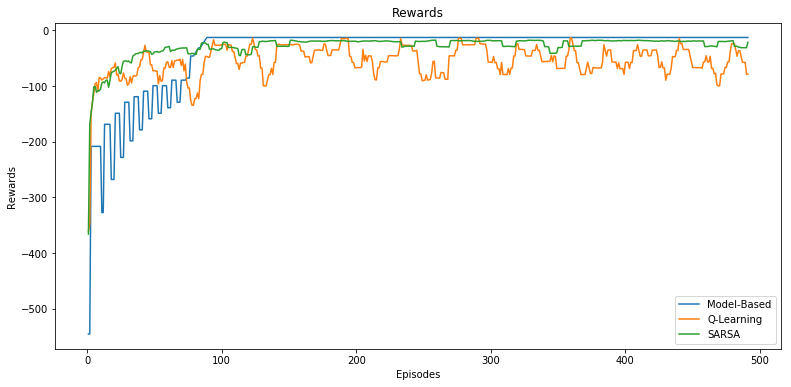

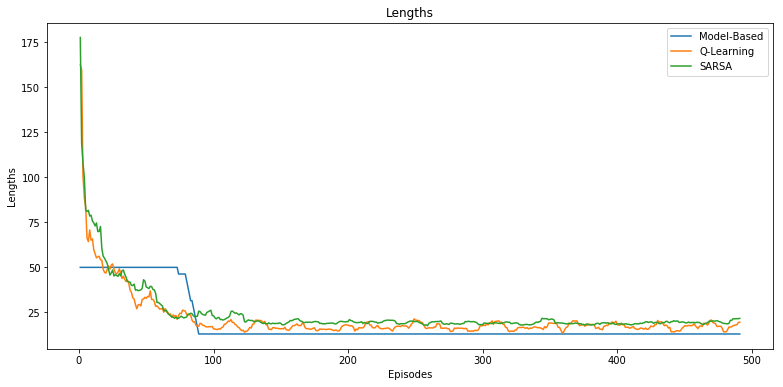

In [27]:
envname = "Cliff-v0"

print("\n----------------------------------------------------------------")
print("\tEnvironment: ", envname)
print("----------------------------------------------------------------\n")

env = gym.make(envname)
env.render()

# Learning parameters
episodes = 500
ep_limit = 50
vmaxiters = 50
alpha = .3
gamma = .9
epsilon = .1
delta = 1e-3

rewser = []
lenser = []

litres = np.arange(1, episodes + 1)  # Learning iteration values
window = 10  # Rolling window
mrew = np.zeros(episodes)
mlen = np.zeros(episodes)

t = timer()

# Model-based
_, rews, lengths = model_based(env, episodes, ep_limit, vmaxiters, gamma, delta)
rews = rolling(rews, window)
rewser.append({"x": np.arange(1, len(rews) + 1), "y": rews, "label": "Model-Based"})
lengths = rolling(lengths, window)
lenser.append({"x": np.arange(1, len(lengths) + 1), "y": lengths, "label": "Model-Based"})

# Q-Learning
_, rews, lengths = q_learning(env, episodes, alpha, gamma, epsilon_greedy, epsilon)
rews = rolling(rews, window)
rewser.append({"x": np.arange(1, len(rews) + 1), "y": rews, "ls": "-", "label": "Q-Learning"})
lengths = rolling(lengths, window)
lenser.append({"x": np.arange(1, len(lengths) + 1), "y": lengths, "ls": "-", "label": "Q-Learning"})

# SARSA
_, rews, lengths = sarsa(env, episodes, alpha, gamma, epsilon_greedy, epsilon)
rews = rolling(rews, window)
rewser.append({"x": np.arange(1, len(rews) + 1), "y": rews, "label": "SARSA"})
lengths = rolling(lengths, window)
lenser.append({"x": np.arange(1, len(lengths) + 1), "y": lengths, "label": "SARSA"})

print("Execution time: {0}s".format(round(timer() - t, 4)))

plot(rewser, "Rewards", "Episodes", "Rewards")
plot(lenser, "Lengths", "Episodes", "Lengths")

## Discussion

Can you explain the different trends in the charts?

Correct trends can be seen in the following images: yours should be similar

### Rewards
![rewards](results/rewards.png)

### Lengths
![lengths](results/lengths.png)